### Zero Temperature Spin-Boson Model Dynamics using the Hierarchical Equations of Motion

We will now demonstrate how to use pyTTN to perform OQS dynamics for a spin-boson model using the non-unitary dynamics methods, namely the Hierarchical Equations of Motion (HEOM) and Quasi-Lindblad Pseudomode (pseudomode) methods.  In contrast to the [Star Hamiltonian](#dynamics-using-the-discretised-star-hamiltonian) and [TEDOPA](#dynamics-using-the-tedopa-method) examples, with these approaches we work with density matrices and pseudoboson modes that have in general complex frequency and couple to the system with non-hermitian system-bath coupling terms.    

The two approaches, HEOM and pseudomode, are up to a similarity transformation equivalent, and consequently the process for setting up the two approaches is incredibly similar.  Within pyTTN, this process is simplified through the use of the `pyttn.oqs.ExpFitBosonicBath` class, which similar to the `pyttn.oqs.DiscreteBosonicBath` provides a set of functions allowing or easy set up of non-unitary equation of motion based dynamics methods that make use of a sum-of-exponential decomposition for the bath correlation function. 

In this example, we demonstrate how to perform HEOM calculations for the spin-boson model considered above using pyTTN.  This example can be modified to perform pseudomode dynamics simply by replacing `method="heom"` with `method="pseudomode"`. 

##### Contents

1. [Import The Library](#importing-the-library)

2. [Setting up the Expfit Bosonic Bath](#setting-up-the-expfit-bosonic-bath)

3. [Setting up the System Information](#setting-up-the-system-information)

4. [Building the Generator](#building-the-generator)

5. [Building the ADOs Tensor Network](#building-the-ados-tensor-network)

6. [Preparing for Time Evolution](#preparing-for-time-evolution)

7. [Performing the Time Evolution](#performing-the-time-evolution)

##### Importing the Library

In [268]:
import os
os.environ['OMP_NUM_THREADS']='1'

import sys
sys.path.append("../")

import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline

import pyttn
from pyttn import oqs
from pyttn.utils import visualise_tree

##### Setting up the Expfit Bosonic Bath

In [269]:
#set the method for the pyttn.oqs.ExpFitBosonicBath object
method = "heom"

#number of modes in decomposition
K = 6

#set up the time evolution information
dt = 0.05
tmax = 15
nstep = int(tmax/dt)+1
t = np.arange(nstep+1)*dt

#set up the bath spectral density
alpha = 1.0
s = 1
wc = 5    

#setup the function for evaluating the exponential cutoff spectral density
def J(w):
    return np.abs(np.pi/2*alpha*wc*np.power(w/wc, s)*np.exp(-np.abs(w/wc)))*np.where(w > 0, 1.0, -1.0)

#set up the open quantum system bath object
bath = oqs.BosonicBath(J, beta=None)
dk, zk = bath.expfit(oqs.ESPRITDecomposition(K=K, tmax=nstep*dt, Nt = nstep))

expbath = oqs.ExpFitBosonicBath(dk, zk)

##### Setting up the System Information

In [270]:
L = 30
Lmin = 4

expbath.truncate_modes(pyttn.utils.EnergyTruncation(10*wc, Lmax=L, Lmin=Lmin))

#setup the system information object
sysinf = pyttn.system_modes(1)
sysinf[0] = [pyttn.tls_mode(), pyttn.tls_mode()]

if use_mode_combination:
    mode_comb = pyttn.utils.ModeCombination(nbmax, nhilbmax)
    bsys = expbath.system_information(mode_comb)
else:
    bsys = expbath.system_information()


#construct the system information object by combining the system information with the bath information
sysinf = pyttn.combine_systems(sysinf, bsys)

##### Building the Generator


In [271]:
#set up parameters for the system
delta = 0.5
eps = 0

#set up the total Hamiltonian
H = pyttn.SOP(sysinf.nprimitive_modes())

#add on the system liouvillian - here we are using that sz^T = sz and "sx^T=sx"
H += (eps*pyttn.sOP("sz", 0) + delta*pyttn.sOP("sx", 0)) - (eps*pyttn.sOP("sz", 1)+delta*pyttn.sOP("sx", 1))
H = expbath.add_system_bath_generator(H, [pyttn.sOP("sz", 0), pyttn.sOP("sz", 1)], method=method)


##### Building the ADOs Tensor Network


In [272]:
#construct the topology and capacity trees used for constructing 
chi0 = 8
chi = 32
degree = 2

topo = pyttn.ntree("(1(4(4)))")
capacity = pyttn.ntree("(1(4(4)))")
linds = expbath.add_bath_tree(topo(), degree, chi0, chi0)
expbath.add_bath_tree(capacity(), degree, chi, chi)

A = pyttn.ttn(topo, capacity, dtype=np.complex128)
state = [0] + [0 for i in range(len(bsys))]
A.set_state(state)


##### Preparing for Time Evolution

In [273]:
h = pyttn.sop_operator(H, A, sysinf)


#set up ttns storing the observable to be measured.  Here these are just system observables
#so we form a tree with the same topology as A but with all bath bond dimensions set to 1
obstree = pyttn.ntree("(1(4(4)))")
expbath.add_bath_tree(obstree(), degree, 1, 1)
id_ttn = pyttn.ttn(obstree, dtype=np.complex128)
id_ttn.set_product([np.identity(2).flatten()] + expbath.identity_product_state(method=method))

szop = pyttn.site_operator(pyttn.sOP("sz", 0), sysinf)
mel = pyttn.matrix_element(A)

#set up buffers to store the observable
Sz = np.zeros(nstep+1)

#set up the tdvp object
sweep = pyttn.tdvp(A, h, krylov_dim = 12, expansion='subspace', subspace_neigs = 4, subspace_krylov_dim = 8)
sweep.spawning_threshold = 1e-10
sweep.minimum_unoccupied=0

sweep.dt = dt
sweep.coefficient = -1.0j

##### Performing the Time Evolution

In [274]:
Sz[0] = np.real(mel(szop, A, id_ttn))

#perform the first timestep using a logarithmic discretisation of time over this period.  
#This can be useful to allow for suitable adaptation of weakly occupied single particle 
#functions through the initial time point.
tp = 0
ts = np.logspace(np.log10(dt*1e-5), np.log10(dt), 5)
for i in range(5):
    dti = ts[i]-tp
    sweep.dt = dti
    sweep.step(A, h)
    tp = ts[i]

i=1
#set the values after the first timestep
Sz[i] =np.real(mel(szop, A, id_ttn))
sweep.dt = dt

#now perform standard time stepping
for i in range(1,nstep):
    sweep.step(A, h)
    Sz[i+1] = np.real(mel(szop, A, id_ttn))
    print("step: %d of %d.  Chimax: %d"%(i+1, nstep, A.maximum_bond_dimension()), end='                   \r')
print('                                                       \r')

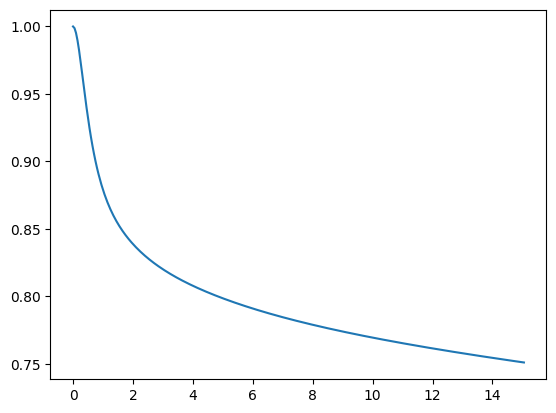

In [275]:
plt.plot(t, Sz)
plt.show()

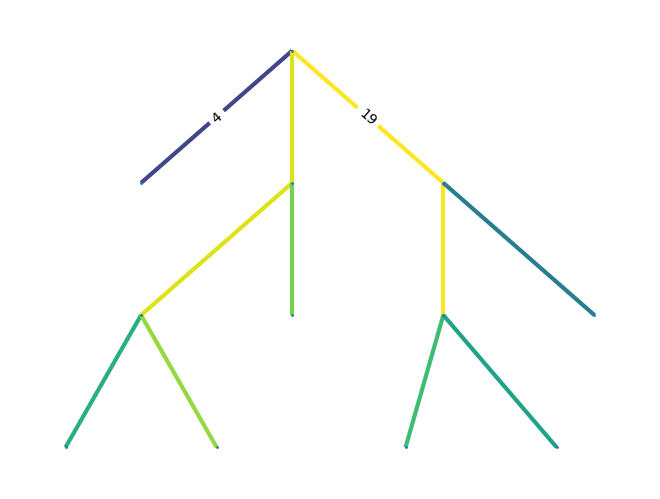

In [276]:
visualise_tree(A, node_size=1, bond_prop="bond dimension")
plt.show()

In [280]:
print(sysinf.mode_dimensions())
print(np.prod(np.array(sysinf.mode_dimensions())))

[4, 900, 900, 256, 36, 16, 16]
7644119040000
